In [66]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.inspection import PartialDependenceDisplay
import sklearn
print('xgboost version', xgb.__version__)
print('sklearn version', sklearn.__version__)
import lime.lime_tabular
import shap
shap.initjs()

xgboost version 2.0.3
sklearn version 1.4.0


## Reference notebook: https://www.kaggle.com/code/maryanalyze/interpret-xgboost-pdp-ice-lime-shap

In [67]:


from sklearn.model_selection import train_test_split
from sklearn import preprocessing
df = pd.read_csv('./train.csv')

df = pd.read_csv('train.csv') #reading data
df.replace('?',np.NaN, inplace=True)



df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1) #dropping columns that are not useful for classifcation
df = df.dropna(axis=0) #dropping nan rows
df.dropna(inplace=True)

le = preprocessing.LabelEncoder() #encoding the categorical variables into numericals
df['Sex'] = le.fit_transform(df['Sex']) #{'female': 0, 'male': 1}
df['Embarked'] = le.fit_transform(df['Embarked']) #{'C': 0, 'Q': 1, 'S': 2}
X = df[['Pclass',  'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked']]
y = df["Survived"].values
train_dataset, test_dataset, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42, stratify = y) #train test split
df_train = train_dataset.copy()
df_test = test_dataset.copy()
X_train = train_dataset.drop('Survived', axis=1)
X_test = test_dataset.drop('Survived', axis=1)



model = xgb.XGBClassifier(eval_metric = 'logloss', n_estimators = 1000, early_stopping_rounds = 5)
model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)],  verbose = False)
bst = model.get_booster()
print('Best num_boost_rounds:', bst.best_iteration)
print('Best negative Logloss:', np.round(bst.best_score,4))
feature_names = X_train.columns




Best num_boost_rounds: 7
Best negative Logloss: 0.4349


In [68]:
df_train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [71]:
sorted(dict(zip(feature_names,model.feature_importances_)).items(), key = lambda x: -x[1])

[('Sex', 0.66446114),
 ('Pclass', 0.15767875),
 ('SibSp', 0.096038565),
 ('Age', 0.029049417),
 ('Fare', 0.024019497),
 ('Parch', 0.017279727),
 ('Embarked', 0.011472901)]

In [73]:
df_train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

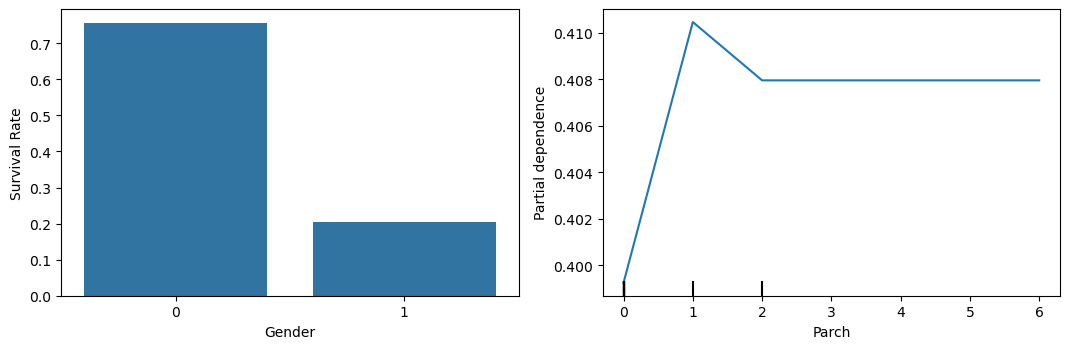

In [77]:
ifeat = 4
my_dpi = 100
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(1080/my_dpi, 360/my_dpi), dpi=my_dpi)

marginal = df_train.groupby('Sex')['Survived'].mean()
sns.barplot(x = marginal.index, y = marginal.values, ax = ax[0])
ax[0].set_xlabel('Gender')
ax[0].set_ylabel('Survival Rate')

pdp = PartialDependenceDisplay.from_estimator(model, X_train.values, features = [ifeat], feature_names = feature_names, ax = ax[1])

plt.tight_layout()
plt.savefig(f'cls_pdp.png', dpi = my_dpi);

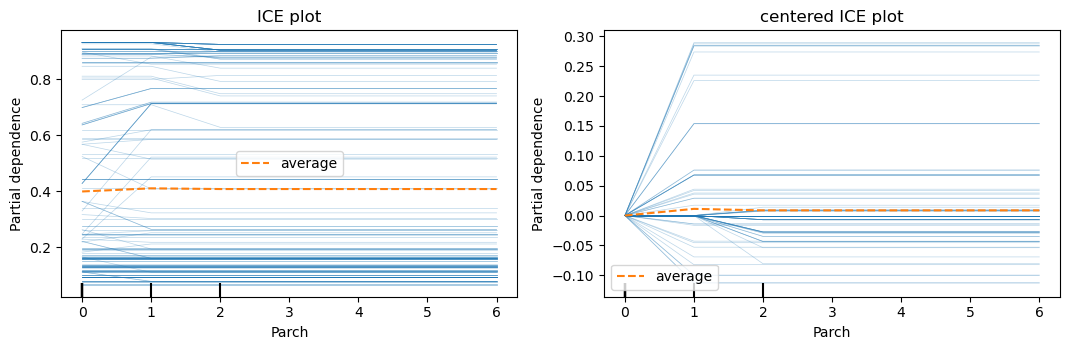

In [78]:
ifeat = 4
my_dpi = 100
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(1080/my_dpi, 360/my_dpi), dpi=my_dpi)

ax[0].set_title('ICE plot')
ax[1].set_title('centered ICE plot')

pdp = PartialDependenceDisplay.from_estimator(model, X_train.values, features = [ifeat], feature_names = feature_names, kind = 'both', subsample = 200, ax = ax[0])
pdpc = PartialDependenceDisplay.from_estimator(model, X_train.values, features = [ifeat], feature_names = feature_names, kind = 'both', subsample = 200, centered = True, ax = ax[1])

plt.tight_layout()
plt.savefig(f'cls_ice.png', dpi = my_dpi);

### ICE plots <a class="anchor" id="23"></a>

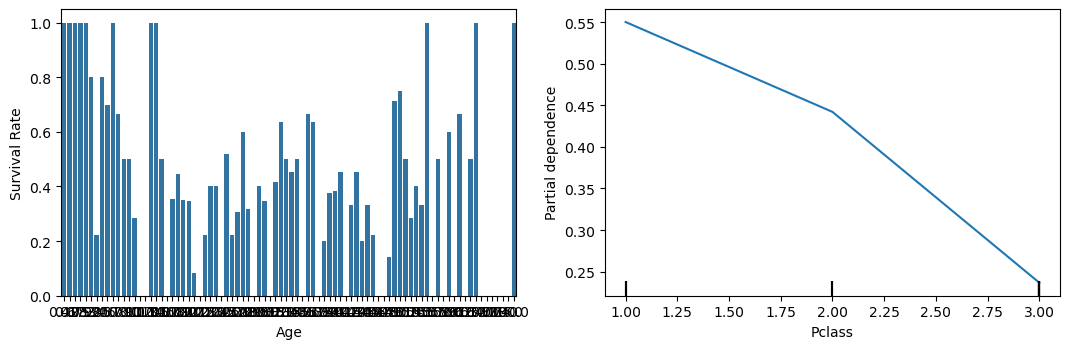

In [82]:
ifeat = 0
my_dpi = 100
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(1080/my_dpi, 360/my_dpi), dpi=my_dpi)




marginal = df_train.groupby('Age')['Survived'].mean()
sns.barplot(x = marginal.index, y = marginal.values, ax = ax[0])
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Survival Rate')



pdp = PartialDependenceDisplay.from_estimator(model, X_train.values, features = [ifeat], feature_names = feature_names, ax = ax[1])

plt.tight_layout()
plt.savefig(f'cls_pdp.png', dpi = my_dpi);

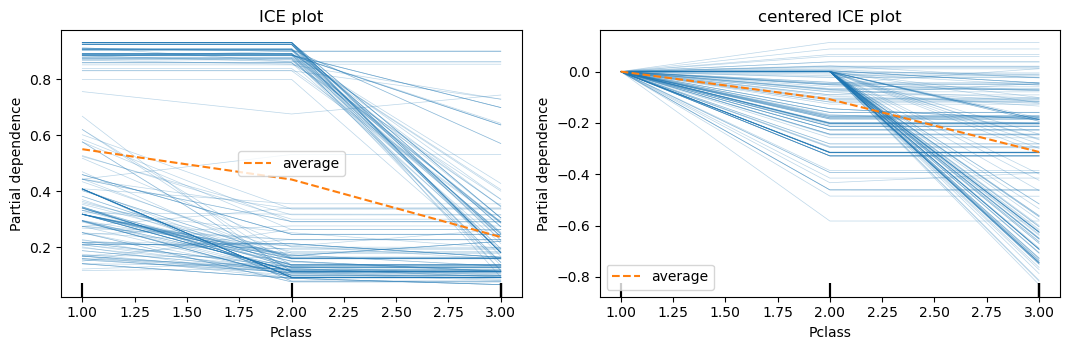

In [83]:
ifeat = 0
my_dpi = 100
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(1080/my_dpi, 360/my_dpi), dpi=my_dpi)

ax[0].set_title('ICE plot')
ax[1].set_title('centered ICE plot')

pdp = PartialDependenceDisplay.from_estimator(model, X_train, features = [ifeat], feature_names = feature_names, kind = 'both', subsample = 200, ax = ax[0])
pdpc = PartialDependenceDisplay.from_estimator(model, X_train, features = [ifeat], feature_names = feature_names, kind = 'both', subsample = 200, centered = True, ax = ax[1])

plt.tight_layout()
plt.savefig(f'cls_ice.png', dpi = my_dpi);

In [14]:
### 2.4 LIME <a class="anchor" id="24"></a>